<a href="https://colab.research.google.com/github/bogdanjianu150/MaskRCNNv2/blob/main/p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==1.15.0
!pip install keras==2.2.5
!pip install h5py==2.10.0
!pip install -U scikit-image==0.16.2

In [4]:
import os
import sys
import json
import datetime
import random
import math
import re
import time
import numpy as np
import skimage.draw
import cv2
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import matplotlib.image as mpimg
from drive.MyDrive.Mask_RCNN.mrcnn import utils
from drive.MyDrive.Mask_RCNN.mrcnn import visualize
from drive.MyDrive.Mask_RCNN.mrcnn.visualize import display_images
import drive.MyDrive.Mask_RCNN.mrcnn.model as modellib
from drive.MyDrive.Mask_RCNN.mrcnn.model import log
from drive.MyDrive.Mask_RCNN.mrcnn.visualize import display_instances
from drive.MyDrive.Mask_RCNN.mrcnn.config import Config
from drive.MyDrive.Mask_RCNN.mrcnn import model as modellib, utils
import tensorflow as tf
from tensorboard import notebook


Using TensorFlow backend.


In [5]:
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/Mask_RCNN")
sys.path.append(ROOT_DIR)  # folderul in care se lucreaza
# calea catre fisierul cu modelul preantrenat
COCO_WEIGHTS_PATH = os.path.join("/content/drive/MyDrive/mask_rcnn_coco.h5")
# folder pentru salvarea modelului (checkpointuri)
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
class CustomConfig(Config):
    #Suprascrierea clasei Config pentru a lucra cu set de date custom
    # Numele configuratiei
    NAME = "object"
   
    #Se foloseste GPU de la Google Colab => se pot procesa 2 imagini
    # Ajustabil pentru resurse mai limitate
    IMAGES_PER_GPU = 1
    #numarul de clase + fundalul
    NUM_CLASSES = 7  # fundal + (carton, sticla, hartie, plastic, metal, gunoi)
    # Numarul de pasi pe epoca de antrenare
    STEPS_PER_EPOCH = 200     #nr de img din setul de antrenare / (nr de placi video * nr de imagini / placa video) = 2000/2 = 1000
    # Se ignora detectiile cu procent < 90%
    DETECTION_MIN_CONFIDENCE = 0.2

In [6]:
dataset_path = os.path.abspath("/content/drive/MyDrive/trashnet")
images_path = os.path.abspath("/content/drive/MyDrive/trashnet/data_tv")


masks_path = os.path.sep.join([dataset_path, "masks_modif.json"])

In [7]:
class CustomDataset(utils.Dataset):
  def load_custom(self, dataset, subset):
        #Functie pentru a incarca setul de date
        #subset reprezinta unul dintre foldere de antrenare sau validare
        #Se adauga clasele : 6 clase
        self.add_class("object", 1, "cardboard")
        self.add_class("object", 2, "glass")
        self.add_class("object", 3, "paper")
        self.add_class("object", 4, "plastic")
        self.add_class("object", 5, "metal")
        self.add_class("object", 6, "trash")
        # self.add_class("object", 3, "xyz") #pentru mai multe clase

        #Se da posibilitatea de selectare dintre subseturile de antrenare sau validare
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset, subset)
        #image_path = os.listdir(self.dataset_dir)
        # Se incarca anotarile
        #Folosind VGG Image Annotator fiecare imagine va avea o anotare de forma:
        # { 'filename': 'imagine.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 9999
        # }
        # Pentru prelucarari se vor folosi in princapi regiunile x si y
        annotations1 = json.load(open(os.path.join(masks_path)))
        annotations = list(annotations1.values())  # in procesarile care urmeaza nu se vor folosi cheile
        image_path = os.listdir(dataset_dir)
        

        #se citesc imaginile din folder
        data = os.listdir(dataset_dir)
        #se initializeaza o lista goala cu scopul de ordonare a imaginilor pentru viitoarele procesari
        images = []
        #iterez prin imagini
        for i in data:
        # k - calea creata folosind numele folderului si fiecare imagine
       
          k = dataset_dir + '/' + str(i)
          filename = k.split(os.path.sep)[-1]
          #filename - numele imaginii fara '' si fara folder (imagine1.jpg)
          images.append(filename)
          #in urma procesarilor se adauga numele imaginii in formatul de mai sus in lista de imagini

      
        # In urma anotarilor se salveaza fisierul in format JSON
        # In cazul in care sunt imagini fara anotari, acestea se ignora
        annotations = [a for a in annotations if a['regions']]
        
        # Adaugarea imaginilor
        #Se porneste de la fisierul de anotari si se itereaza prin el
        for a in annotations:
          
          
            #Se iau coordonatele (x,y) ale punctelor din poligon care se afla in campul 'shape_attributes'
            polygons = [r['shape_attributes'] for r in a['regions']]
            #Iau numele obiectului neprocesat din JSON. (ex: 'glass86.jpg12) - conform fisierului JSON 
            objects_init = a['filename'] 
            #Folosind operatii pe string se poate lua numele efectiv al clasei care corespunde obiectului anterior
            # Se despart literele de cifre in 2 stringuri separate
            # ex: (glass, 86)
            res = [re.findall(r'(\w+?)(\d+)', objects_init)[0] ]
            #Se selecteaza doar primul element care va fi corespondent numelui clasei
            # astfel se realizeaza o corespondenta clasa - imagine
            objects = [res[0][0]]
            print("objects:",objects)
            #Initilizarea unui dictionar care de tipul {"clasa" : "id"} - util pentru viitoare procesari
            name_dict = {"cardboard": 1,"glass": 2, "paper":3, "plastic":4, "metal":5, "trash":6} #,"xyz": 3}
            # a este numele clasei, iar folosind-o pe aceasta (cheia) se poate extrage valoare din dictionar (id)
            #Util pentru crearea unui id unic pentru fiecare obiect. 
            # pentru a nu exista dublica ex. (glass82 -> id: 82, dar metal82 -> id : ?)
            num_ids = [name_dict.get(a) for a in objects]
     
         
            #functia load_mask() are nevoie de dimensiunea imaginii pentru a converti poligoanele in masti
            print("numids",num_ids)
            
            
            for i in images:
              #deoarece exista 2 posibilitati de subfoldere - pentru antrenare sau validare 
              #trebuie izolate doar anotarile din fisierul respectiv
              #se parcurge lista de imagini si se gasesc anotarile corespunzatoare elementelor
              if i == a['filename']:

                #contruiesc calea pentru a citi imaginea
                p = dataset_dir + "/" + str(i)
                image = skimage.io.imread(p)
                #extrag dimensiunile
                height, width = image.shape[:2]
                #adaug imaginea utilizand parametrii aflati anterior
                self.add_image(
                "object",  #in cazul unei singure clase se poate adauga direct numele clasei
                image_id=a["filename"],  #folosesc "filename" pe post de id
                path = p,
                width=width, height=height,
                polygons=polygons,
                num_ids = num_ids
                )
        
  def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        #functia care genereaza mastile pentru fiecare imagine
        #returneaza un vector de tip boolean cu dimensiunea [height, width, instance_count]
        #cu o  masca pe instanta
        #in cazul in care imaginea nu este din clasele de mai sus se apeleaza functia parinte
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        
        #conversia poligoanelor in masti
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
          #se cauta pixelii din interiorul poligonului si se instantiaza cu valoarea 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask , num_ids 

  def image_reference(self, image_id):
        #returnez calea imaginii
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
#vizualizare modelului si a altor parametrii

config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH


model.load_weights(weights_path, by_name=True, exclude=[
           "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
#vizualizarea GPU-ului oferit de colab
!nvidia-smi

In [ ]:
dataset_train = CustomDataset()
dataset_train.load_custom(images_path, "train")
dataset_train.prepare()

In [ ]:
dataset_val = CustomDataset()
dataset_val.load_custom(images_path,  "val")
dataset_val.prepare()

In [ ]:
config = CustomConfig()
config.display()
MODEL_DIR = '/content/drive/MyDrive/Mask_RCNN/logs'

In [13]:
#setarea configului pentru predictie


class InferenceConfig(CustomConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.2

In [ ]:
#vizualizarea modelului si a altor parametrii pentru predictie

iconfig = InferenceConfig()
iconfig.display()

In [15]:
model_inference = modellib.MaskRCNN(mode="inference", config=iconfig, model_dir=MODEL_DIR)
mean_average_precision_callback = modellib.MeanAveragePrecisionCallback(model,model_inference,
                                                                        dataset_val, calculate_map_at_every_X_epoch=5, verbose=1)
model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=20,
                layers='heads',
                custom_callbacks=[mean_average_precision_callback])
model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE/10,
                epochs=40,
                layers='all',
            custom_callbacks=[mean_average_precision_callback])
model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE/100,
                epochs=50,
                layers='all',
            custom_callbacks=[mean_average_precision_callback])





Instructions for updating:
Use `tf.cast` instead.

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Mask_RCNN/logs/object20220518T1908/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeD

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/20
200/200 [==============================] - 150s 750ms/step - loss: 1.5505 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4046 - mrcnn_class_loss: 0.2012 - mrcnn_bbox_loss: 0.6895 - mrcnn_mask_loss: 0.2420 - val_loss: 0.9902 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 0.3208 - val_mrcnn_class_loss: 0.1273 - val_mrcnn_bbox_loss: 0.4025 - val_mrcnn_mask_loss: 0.1353

Epoch 2/20
200/200 [==============================] - 105s 524ms/step - loss: 0.9371 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.3771 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.2731 - mrcnn_mask_loss: 0.1604 - val_loss: 1.0182 - val_rpn_class_loss: 0.0074 - val_rpn_bbox_loss: 0.3275 - val_mrcnn_class_loss: 0.1602 - val_mrcnn_bbox_loss: 0.3109 - val_mrcnn_mask_loss: 0.2122
Epoch 3/20
200/200 [==============================] - 107s 533ms/step - loss: 0.8359 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.3284 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.1477 - val_loss: 0.8012 - val

ERROR:root:Error processing image {'id': 'trash86.jpg', 'source': 'object', 'path': '/content/drive/MyDrive/trashnet/data_tv/train/trash86.jpg', 'width': 512, 'height': 384, 'polygons': [{'name': 'polygon', 'all_points_x': [348, 353, 242, 178, 134, 98, 106, 138, 162, 163, 178, 230, 210, 202, 227, 242, 252, 227, 204, 166, 140, 174, 194, 258, 310, 318], 'all_points_y': [80, 43, 53, 79, 130, 175, 230, 257, 279, 293, 296, 285, 318, 373, 380, 296, 260, 231, 228, 211, 181, 143, 107, 87, 76, 95]}, {'name': 'polygon', 'all_points_x': [501, 440, 483, 380, 509, 508], 'all_points_y': [102, 213, 300, 375, 379, 99]}], 'num_ids': [6]}
Traceback (most recent call last):
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1710, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1266, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but

200/200 [==============================] - 107s 534ms/step - loss: 0.7192 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.3384 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.1196 - val_loss: 0.8263 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.4713 - val_mrcnn_class_loss: 0.0711 - val_mrcnn_bbox_loss: 0.1626 - val_mrcnn_mask_loss: 0.1162
Epoch 8/20
200/200 [==============================] - 107s 537ms/step - loss: 0.7533 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.3778 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.1184 - val_loss: 0.6797 - val_rpn_class_loss: 0.0042 - val_rpn_bbox_loss: 0.2872 - val_mrcnn_class_loss: 0.1104 - val_mrcnn_bbox_loss: 0.1578 - val_mrcnn_mask_loss: 0.1202
Epoch 9/20
193/200 [===========================>..] - ETA: 3s - loss: 0.7590 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.3668 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.1185

ERROR:root:Error processing image {'id': 'plastic179.jpg', 'source': 'object', 'path': '/content/drive/MyDrive/trashnet/data_tv/train/plastic179.jpg', 'width': 512, 'height': 384, 'polygons': [{'name': 'polygon', 'all_points_x': [150, 152, 180, 202, 197, 179, 157], 'all_points_y': [167, 141, 135, 151, 178, 185, 173]}, {'name': 'polygon', 'all_points_x': [181, 197, 204, 222, 247, 265, 265, 250, 224, 209, 183, 166, 163], 'all_points_y': [219, 203, 199, 207, 214, 225, 251, 260, 263, 276, 275, 254, 233]}], 'num_ids': [4]}
Traceback (most recent call last):
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1710, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1266, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 2


194/200 [============================>.] - ETA: 2s - loss: 0.7591 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.3677 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.1182

ERROR:root:Error processing image {'id': 'plastic179.jpg', 'source': 'object', 'path': '/content/drive/MyDrive/trashnet/data_tv/train/plastic179.jpg', 'width': 512, 'height': 384, 'polygons': [{'name': 'polygon', 'all_points_x': [150, 152, 180, 202, 197, 179, 157], 'all_points_y': [167, 141, 135, 151, 178, 185, 173]}, {'name': 'polygon', 'all_points_x': [181, 197, 204, 222, 247, 265, 265, 250, 224, 209, 183, 166, 163], 'all_points_y': [219, 203, 199, 207, 214, 225, 251, 260, 263, 276, 275, 254, 233]}], 'num_ids': [4]}
Traceback (most recent call last):
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1710, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1266, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 2


200/200 [==============================] - 107s 536ms/step - loss: 0.7545 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.3645 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.1184 - val_loss: 0.8492 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.3901 - val_mrcnn_class_loss: 0.1512 - val_mrcnn_bbox_loss: 0.1655 - val_mrcnn_mask_loss: 0.1338
Epoch 10/20
200/200 [==============================] - 107s 536ms/step - loss: 0.8042 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.3975 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.1236 - val_loss: 0.8484 - val_rpn_class_loss: 0.0052 - val_rpn_bbox_loss: 0.4046 - val_mrcnn_class_loss: 0.1102 - val_mrcnn_bbox_loss: 0.1872 - val_mrcnn_mask_loss: 0.1412
Calculating mAP...
Loaded weights for the inference model (last checkpoint of the train model): /content/drive/MyDrive/Mask_RCNN/logs/object20220518T1908/mask_rcnn_object_0010.h5
Re-starting from epoch 10
mAP at epoch 10 is: 0.517834595959596
Epoch 1

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 21/40
200/200 [==============================] - 229s 1s/step - loss: 0.4975 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.2307 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.0869 - val_loss: 0.5522 - val_rpn_class_loss: 0.0052 - val_rpn_bbox_loss: 0.2845 - val_mrcnn_class_loss: 0.0808 - val_mrcnn_bbox_loss: 0.0920 - val_mrcnn_mask_loss: 0.0897
Epoch 22/40
200/200 [==============================] - 168s 842ms/step - loss: 0.4482 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.0797 - val_loss: 0.4358 - val_rpn_class_loss: 0.0044 - val_rpn_bbox_loss: 0.1930 - val_mrcnn_class_loss: 0.0807 - val_mrcnn_bbox_loss: 0.0577 - val_mrcnn_mask_loss: 0.1001
Epoch 23/40
200/200 [==============================] - 169s 847ms/step - loss: 0.4705 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.2052 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1088 - val_loss: 0.5372 - val_rp

ERROR:root:Error processing image {'id': 'plastic179.jpg', 'source': 'object', 'path': '/content/drive/MyDrive/trashnet/data_tv/train/plastic179.jpg', 'width': 512, 'height': 384, 'polygons': [{'name': 'polygon', 'all_points_x': [150, 152, 180, 202, 197, 179, 157], 'all_points_y': [167, 141, 135, 151, 178, 185, 173]}, {'name': 'polygon', 'all_points_x': [181, 197, 204, 222, 247, 265, 265, 250, 224, 209, 183, 166, 163], 'all_points_y': [219, 203, 199, 207, 214, 225, 251, 260, 263, 276, 275, 254, 233]}], 'num_ids': [4]}
Traceback (most recent call last):
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1710, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1266, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 2


186/200 [==========================>...] - ETA: 10s - loss: 0.3512 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1294 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0951

ERROR:root:Error processing image {'id': 'plastic179.jpg', 'source': 'object', 'path': '/content/drive/MyDrive/trashnet/data_tv/train/plastic179.jpg', 'width': 512, 'height': 384, 'polygons': [{'name': 'polygon', 'all_points_x': [150, 152, 180, 202, 197, 179, 157], 'all_points_y': [167, 141, 135, 151, 178, 185, 173]}, {'name': 'polygon', 'all_points_x': [181, 197, 204, 222, 247, 265, 265, 250, 224, 209, 183, 166, 163], 'all_points_y': [219, 203, 199, 207, 214, 225, 251, 260, 263, 276, 275, 254, 233]}], 'num_ids': [4]}
Traceback (most recent call last):
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1710, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1266, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 2


200/200 [==============================] - 169s 847ms/step - loss: 0.3521 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0942 - val_loss: 0.2971 - val_rpn_class_loss: 0.0046 - val_rpn_bbox_loss: 0.1322 - val_mrcnn_class_loss: 0.0665 - val_mrcnn_bbox_loss: 0.0319 - val_mrcnn_mask_loss: 0.0619
Epoch 29/40
200/200 [==============================] - 169s 847ms/step - loss: 0.3016 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1237 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.0646 - val_loss: 0.3524 - val_rpn_class_loss: 0.0053 - val_rpn_bbox_loss: 0.1196 - val_mrcnn_class_loss: 0.0774 - val_mrcnn_bbox_loss: 0.0760 - val_mrcnn_mask_loss: 0.0740
Epoch 30/40
200/200 [==============================] - 169s 847ms/step - loss: 0.3171 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.0918 - val_loss: 0.4042 - val_rpn_class_l

ERROR:root:Error processing image {'id': 'trash86.jpg', 'source': 'object', 'path': '/content/drive/MyDrive/trashnet/data_tv/train/trash86.jpg', 'width': 512, 'height': 384, 'polygons': [{'name': 'polygon', 'all_points_x': [348, 353, 242, 178, 134, 98, 106, 138, 162, 163, 178, 230, 210, 202, 227, 242, 252, 227, 204, 166, 140, 174, 194, 258, 310, 318], 'all_points_y': [80, 43, 53, 79, 130, 175, 230, 257, 279, 293, 296, 285, 318, 373, 380, 296, 260, 231, 228, 211, 181, 143, 107, 87, 76, 95]}, {'name': 'polygon', 'all_points_x': [501, 440, 483, 380, 509, 508], 'all_points_y': [102, 213, 300, 375, 379, 99]}], 'num_ids': [6]}
Traceback (most recent call last):
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1710, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1266, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but

108/200 [===============>..............] - ETA: 1:10 - loss: 0.3741 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1778 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.0861

ERROR:root:Error processing image {'id': 'trash86.jpg', 'source': 'object', 'path': '/content/drive/MyDrive/trashnet/data_tv/train/trash86.jpg', 'width': 512, 'height': 384, 'polygons': [{'name': 'polygon', 'all_points_x': [348, 353, 242, 178, 134, 98, 106, 138, 162, 163, 178, 230, 210, 202, 227, 242, 252, 227, 204, 166, 140, 174, 194, 258, 310, 318], 'all_points_y': [80, 43, 53, 79, 130, 175, 230, 257, 279, 293, 296, 285, 318, 373, 380, 296, 260, 231, 228, 211, 181, 143, 107, 87, 76, 95]}, {'name': 'polygon', 'all_points_x': [501, 440, 483, 380, 509, 508], 'all_points_y': [102, 213, 300, 375, 379, 99]}], 'num_ids': [6]}
Traceback (most recent call last):
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1710, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1266, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but

200/200 [==============================] - 167s 836ms/step - loss: 0.3746 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1602 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.0961 - val_loss: 0.2915 - val_rpn_class_loss: 0.0034 - val_rpn_bbox_loss: 0.1025 - val_mrcnn_class_loss: 0.0717 - val_mrcnn_bbox_loss: 0.0350 - val_mrcnn_mask_loss: 0.0788
Epoch 37/40
200/200 [==============================] - 172s 862ms/step - loss: 0.2855 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.0854 - val_loss: 0.2534 - val_rpn_class_loss: 0.0023 - val_rpn_bbox_loss: 0.0904 - val_mrcnn_class_loss: 0.0565 - val_mrcnn_bbox_loss: 0.0296 - val_mrcnn_mask_loss: 0.0746
Epoch 38/40
200/200 [==============================] - 174s 871ms/step - loss: 0.2955 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.0798 - val_loss: 0.2355 - val_rpn_class_l

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 41/50
200/200 [==============================] - 232s 1s/step - loss: 0.2348 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0827 - val_loss: 0.3904 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.0635 - val_mrcnn_class_loss: 0.0562 - val_mrcnn_bbox_loss: 0.0256 - val_mrcnn_mask_loss: 0.2436
Epoch 42/50
200/200 [==============================] - 172s 861ms/step - loss: 0.2316 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0683 - val_loss: 0.2222 - val_rpn_class_loss: 0.0021 - val_rpn_bbox_loss: 0.0740 - val_mrcnn_class_loss: 0.0455 - val_mrcnn_bbox_loss: 0.0344 - val_mrcnn_mask_loss: 0.0662
Epoch 43/50
153/200 [=====================>........] - ETA: 37s - loss: 0.2184 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0689 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0650

ERROR:root:Error processing image {'id': 'plastic179.jpg', 'source': 'object', 'path': '/content/drive/MyDrive/trashnet/data_tv/train/plastic179.jpg', 'width': 512, 'height': 384, 'polygons': [{'name': 'polygon', 'all_points_x': [150, 152, 180, 202, 197, 179, 157], 'all_points_y': [167, 141, 135, 151, 178, 185, 173]}, {'name': 'polygon', 'all_points_x': [181, 197, 204, 222, 247, 265, 265, 250, 224, 209, 183, 166, 163], 'all_points_y': [219, 203, 199, 207, 214, 225, 251, 260, 263, 276, 275, 254, 233]}], 'num_ids': [4]}
Traceback (most recent call last):
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1710, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1266, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 2


154/200 [======================>.......] - ETA: 36s - loss: 0.2187 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.0650

ERROR:root:Error processing image {'id': 'plastic179.jpg', 'source': 'object', 'path': '/content/drive/MyDrive/trashnet/data_tv/train/plastic179.jpg', 'width': 512, 'height': 384, 'polygons': [{'name': 'polygon', 'all_points_x': [150, 152, 180, 202, 197, 179, 157], 'all_points_y': [167, 141, 135, 151, 178, 185, 173]}, {'name': 'polygon', 'all_points_x': [181, 197, 204, 222, 247, 265, 265, 250, 224, 209, 183, 166, 163], 'all_points_y': [219, 203, 199, 207, 214, 225, 251, 260, 263, 276, 275, 254, 233]}], 'num_ids': [4]}
Traceback (most recent call last):
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1710, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1266, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 2


200/200 [==============================] - 174s 868ms/step - loss: 0.2105 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.0637 - val_loss: 0.2232 - val_rpn_class_loss: 9.7495e-04 - val_rpn_bbox_loss: 0.0702 - val_mrcnn_class_loss: 0.0628 - val_mrcnn_bbox_loss: 0.0300 - val_mrcnn_mask_loss: 0.0592
Epoch 44/50
200/200 [==============================] - 174s 869ms/step - loss: 0.2214 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0689 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0672 - val_loss: 0.2935 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.0972 - val_mrcnn_class_loss: 0.0486 - val_mrcnn_bbox_loss: 0.0351 - val_mrcnn_mask_loss: 0.1112
Epoch 45/50
117/200 [================>.............] - ETA: 1:06 - loss: 0.2562 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0688 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.0943

ERROR:root:Error processing image {'id': 'trash86.jpg', 'source': 'object', 'path': '/content/drive/MyDrive/trashnet/data_tv/train/trash86.jpg', 'width': 512, 'height': 384, 'polygons': [{'name': 'polygon', 'all_points_x': [348, 353, 242, 178, 134, 98, 106, 138, 162, 163, 178, 230, 210, 202, 227, 242, 252, 227, 204, 166, 140, 174, 194, 258, 310, 318], 'all_points_y': [80, 43, 53, 79, 130, 175, 230, 257, 279, 293, 296, 285, 318, 373, 380, 296, 260, 231, 228, 211, 181, 143, 107, 87, 76, 95]}, {'name': 'polygon', 'all_points_x': [501, 440, 483, 380, 509, 508], 'all_points_y': [102, 213, 300, 375, 379, 99]}], 'num_ids': [6]}
Traceback (most recent call last):
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1710, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1266, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but

118/200 [================>.............] - ETA: 1:05 - loss: 0.2562 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0684 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.0939

ERROR:root:Error processing image {'id': 'trash86.jpg', 'source': 'object', 'path': '/content/drive/MyDrive/trashnet/data_tv/train/trash86.jpg', 'width': 512, 'height': 384, 'polygons': [{'name': 'polygon', 'all_points_x': [348, 353, 242, 178, 134, 98, 106, 138, 162, 163, 178, 230, 210, 202, 227, 242, 252, 227, 204, 166, 140, 174, 194, 258, 310, 318], 'all_points_y': [80, 43, 53, 79, 130, 175, 230, 257, 279, 293, 296, 285, 318, 373, 380, 296, 260, 231, 228, 211, 181, 143, 107, 87, 76, 95]}, {'name': 'polygon', 'all_points_x': [501, 440, 483, 380, 509, 508], 'all_points_y': [102, 213, 300, 375, 379, 99]}], 'num_ids': [6]}
Traceback (most recent call last):
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1710, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/MyDrive/Mask_RCNN/mrcnn/model.py", line 1266, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but

200/200 [==============================] - 174s 869ms/step - loss: 0.2421 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0701 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0822 - val_loss: 0.2512 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.1036 - val_mrcnn_class_loss: 0.0535 - val_mrcnn_bbox_loss: 0.0278 - val_mrcnn_mask_loss: 0.0618
Calculating mAP...
Loaded weights for the inference model (last checkpoint of the train model): /content/drive/MyDrive/Mask_RCNN/logs/object20220518T1908/mask_rcnn_object_0045.h5
Re-starting from epoch 45
mAP at epoch 45 is: 0.7146464646464646
Epoch 46/50
200/200 [==============================] - 170s 852ms/step - loss: 0.2152 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0586 - val_loss: 0.3268 - val_rpn_class_loss: 0.0039 - val_rpn_bbox_loss: 0.1038 - val_mrcnn_class_loss: 0.0749 - val_mrcnn_bbox_loss: 0.0519 - val_mrcnn_mask_loss: 0.0924
Epoch 

In [ ]:
#citire si incarca a setului de date de validare

dataset = CustomDataset()
dataset.load_custom(images_path, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

In [17]:
#incarcarea fisierului cu modelul cu parametru de predictie

MODEL_DIR = '/content/drive/MyDrive/Mask_RCNN/logs'
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=iconfig)
weights = model.find_last()
#weights = '/content/drive/MyDrive/Mask_RCNN/logs/object20220320T1635/mask_rcnn_object_0010.h5'
print("Loading weights ", weights)
model.load_weights(weights, by_name=True)


Loading weights  /content/drive/MyDrive/Mask_RCNN/logs/object20220518T1908/mask_rcnn_object_0050.h5
Re-starting from epoch 50


In [ ]:
model.keras_model.summary()

In [19]:
def get_ax(rows=1, cols=1, size=16):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    5.00000  max:    5.00000  int32
gt_bbox                  shape: (1, 4)                min:  308.00000  max:  734.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8
Processing 1 images
image                    shape: (384, 512, 3)         min:    0.00000  max:  246.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  118.30000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  float64
anchors     

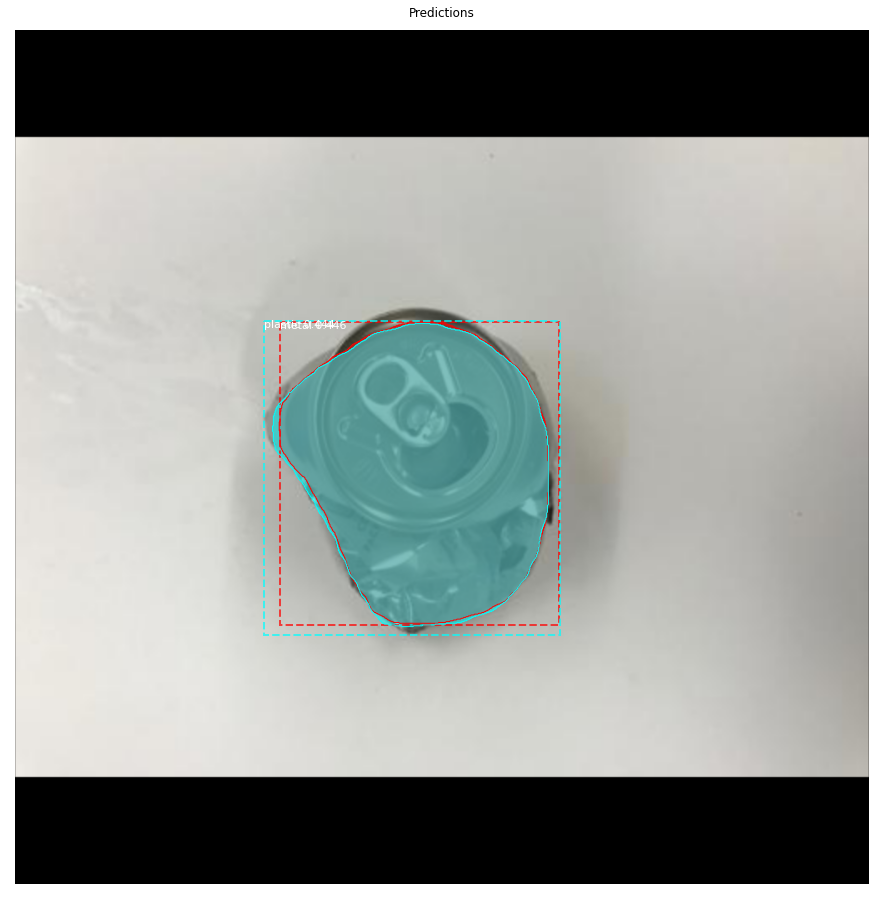

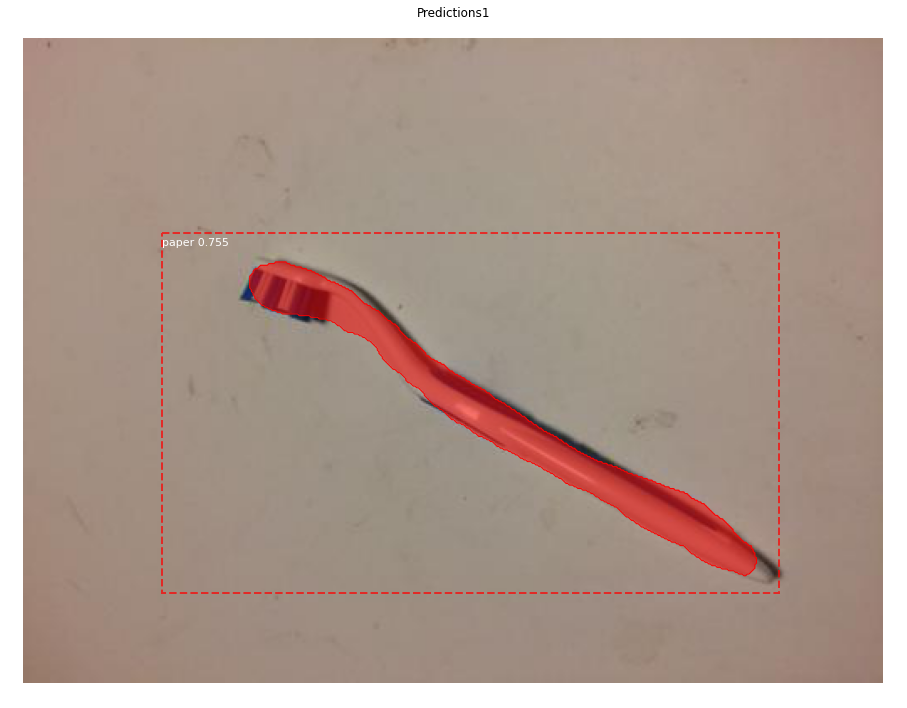

In [41]:
#aleg o imagine random pentru a fi prezisa
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
  modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
#print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
#mAP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])


# aleg o noua imagine care nu este in setul de validare
path_to_new_image = '/content/drive/MyDrive/trashnet/data_tv/train/trash134.jpg'
image1 = mpimg.imread(path_to_new_image)
results1 = model.detect([image1], verbose=1)
# afisare rezultate
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")